## Background about GR system simulation wrapper

Our GR system (`gr_ipc.jar`) is a goal recognition tool which can return a CSV file contains all the inference results of a certain domain with a specific parameter settings. The inference results are divided into 5 groups based on observation percentage (10%, 30%, 50%, 70% & 100%).

For example, in `blocks-world` 10% group, there are multiple problems (testing cases) to test how well our GR system can perform in `blocks-world` domain if we only observe 10% actions. Hence, our GR system will also return multiple results for this 10% group. Having the multiple results, we can calculate average precision for 10% group (`p_10`), average recall for 10% group (`r_10`) and average accuracy for 10% group (`a_10`). 

Similarly, we also calculate `p_30`, `r_30`, `a_30`, `p_50`, `r_50`, `a_50`, `p_70`, `r_70`, `a_70`, `p_100`, `r_100`, `a_100` and `p_avg`, `r_avg`, `a_avg` (notice `_avg` means the average over all 10%, 30%, 50%, 70% and 100% groups). For a certain domain with a certain parameter settings, we can calculate all the statistics above. 

Then we use the [EMA-workbench](https://emaworkbench.readthedocs.io/en/latest/index.html) to define a model to wrap up our GR system. The EMA-workbench provides simulation functions to randomly select parameters within pre-defined ranges and then run the GR system for many times (Simulation). It will collect performance statistics (`p_10`, `r_10`, `a_10`, `p_30`, `r_30`, `a_30`, `p_50`, `r_50`, `a_50`, `p_70`, `r_70`, `a_70`, `p_100`, `r_100`, `a_100`, `p_avg`, `r_avg`, `a_avg`) corresponding to each set of randomly selected parameters. The simulated performance statistics are stored in a `.tar.gz` files, it will be analysed by this notebook in following sections.

At this stage, the model (including uncertainties, levers, constants and outcomes) is defined in another python module `model.py`. This module is imported by another python program `experiment_simulator.py`.

**Data:** There are two directories `./topk/` and `./diverse/` to store plans generated by top-k and diverse planner correspendingly. 

In either directory, the simulator will run 1000 scenarios on each domain using latin hypercude sampling, the experiment results are saved in `1000_<domain>.tar.gz`. And it will run 10500 scenarios (base number = 1050) on each domain using SOBOL sampling, the results are saved in `1050_<domain>.tar.gz`

In this notebook, we assume all experimental simulations are done and we have obtained all the results saved in `.tar.gz` files. So, we just load the stored data and do sensitivity analysis.

## Requirements

Install the following requirements if they haven't been installed. Be careful with python version, we are using python3. Also be careful with `pip3`, some machine is just `pip`. If you found that some library can not be imported, just put `!` in the front and use `pip3` to install within the jupyter notebook environment.

```sh
! pip3 install <package_name>
```

Or

```
! pip install <package_name>
```


In [2]:
# install packages within jupyter notebook
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install seaborn
#!pip3 install matplotlib
#!pip3 install ema_workbench
#!pip3 install SALib

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ema_workbench import load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import prim

## Show feature scores and plots

In [2]:
# for feature score and plots
def show_feature_score(results):
    experiments, outcomes = results
    x = experiments
    y = outcomes

    fs = feature_scoring.get_feature_scores_all(x, y)
    plt.figure(figsize = (20,5))
    sns.heatmap(fs, cmap='viridis', annot=True)
    plt.show()
    
def show_points(results, label):
    experiments, outcomes = results
    
    # partial dict
    if label == "avg":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_avg", "r_avg", "a_avg"])
    if label == "100":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_100", "r_100", "a_100"])
    if label == "70":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_70", "r_70", "a_70"])
    if label == "50":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_50", "r_50", "a_50"])
    if label == "30":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_30", "r_30", "a_30"])
    if label == "10":
        partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_10", "r_10", "a_10"])

    fig, axes = pairs_plotting.pairs_scatter(experiments, partial_outcomes, group_by='policy',
                                             legend=False)
    fig.set_size_inches(8,8)
    plt.show()
    
def display_scores_and_plots(results):
    show_feature_score(results)
    show_points(results, "avg")
    show_points(results, "100")
    show_points(results, "70")
    show_points(results, "50")
    show_points(results, "30")
    show_points(results, "10")
    

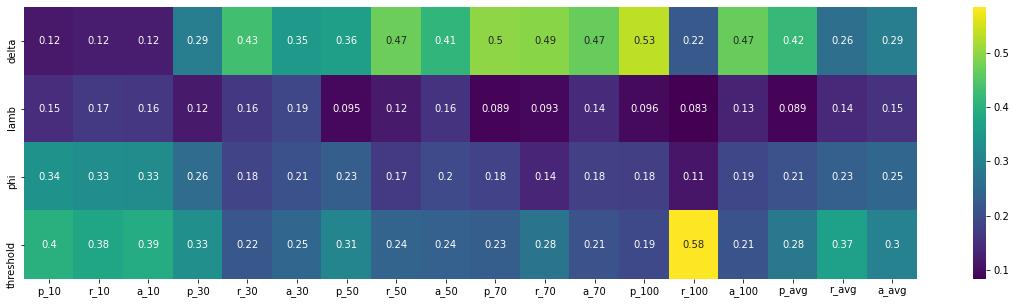

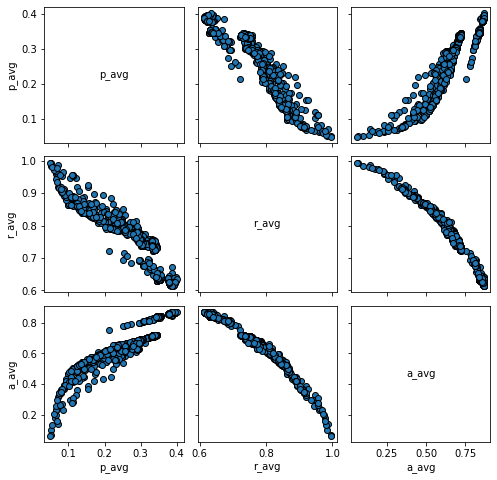

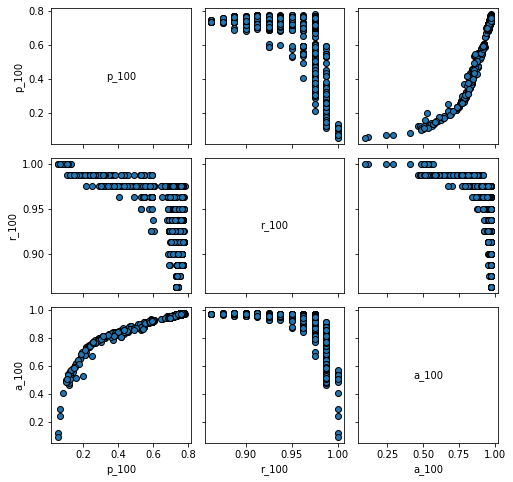

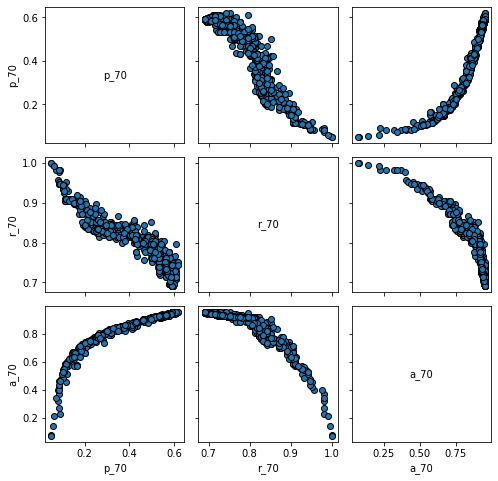

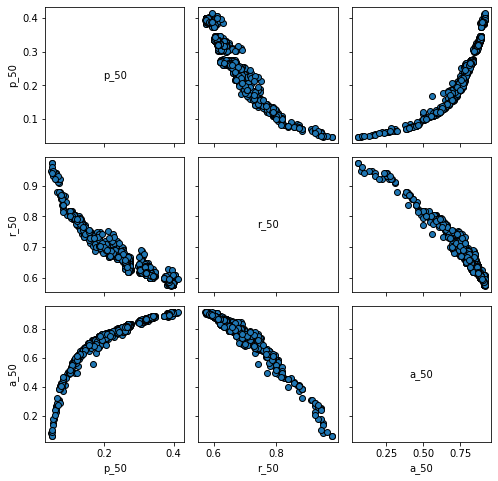

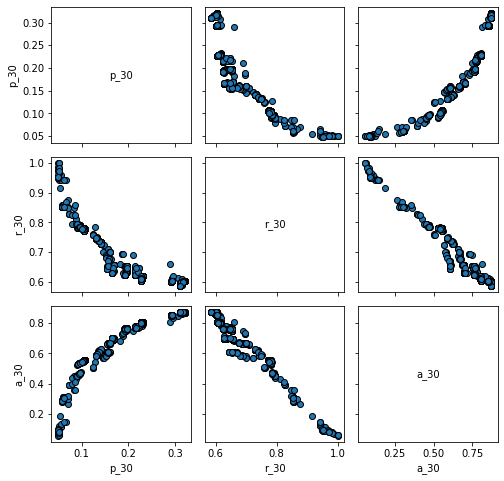

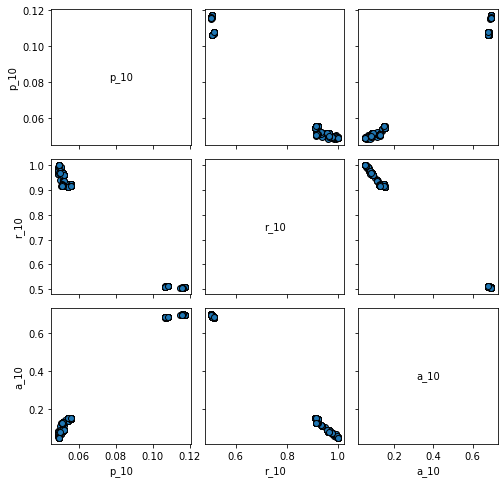

In [3]:
# specify a domain: (select one of below)
domain_name = "blocks-world"
#domain_name = "campus"
#domain_name = "depots"
#domain_name = "driverlog"
#domain_name = "dwr"
#domain_name = "easy-ipc-grid"
#domain_name = "ferry"
#domain_name = "intrusion-detection"
#domain_name = "kitchen"
#domain_name = "logistics"
#domain_name = "miconic"
#domain_name = "rovers"
#domain_name = "satellite"
#domain_name = "sokoban"
#domain_name = "zeno-travel"

# load data
results = load_results('./diverse/1000_' + domain_name + '.tar.gz')

# show feature score and plots
display_scores_and_plots(results)

In [20]:
label = "threshold"
print(results[0][label].min())
print(results[0][label].max())
print(results[0][label].mean())
print(results[0][label].var())
print(results[0][label].std())

0.600213160587449
0.9998585201442004
0.800000372523102
0.013346638296535008
0.11552765165333799


In [28]:
results[1]["a_avg"].min()
results[1]["a_avg"].max()
results[1]["a_avg"].mean()
results[1]["a_avg"].var()
results[1]["a_avg"].std()

0.1283562913273

## PRIM Algorithm

Once we get simultion results stored in `.tar.gz` file. We can apply PRIM algorithm to show what ranges of parameters lead to better performance. Here, we used `a_avg` as a metric to filter out the experiments with top 10% average accuracy (`a_avg`). There are **two steps** for finding the parameter ranges.

In [4]:
# load functions for PRIM algorithm
def get_top(results, percentage, metric):
    experiments, outcomes = results
    experiments[metric] = outcomes[metric]
    num = int(len(experiments.index) * percentage)
    df = experiments.sort_values(by=[metric], ascending=False).head(num)
    
    '''
    # show the dataframe
    print(df)
    range_list = list(df["threshold"])
    range_list.sort()
    # print(range_list)
    print("threshold range: ", range_list[0], range_list[-1])
    
    range_list = list(df["lamb"])
    range_list.sort()
    print("lamb range: ", range_list[0], range_list[-1])
    
    range_list = list(df["delta"])
    range_list.sort()
    print("delta range: ", range_list[0], range_list[-1])
    
    range_list = list(df["phi"])
    range_list.sort()
    print("phi range: ", range_list[0], range_list[-1])
    '''
    return df.tail(1)["a_avg"]

def find_box(results, metric, lower_limit):
    experiments1, outcomes = results
    x = experiments1
    y = outcomes[metric] >= lower_limit

    prim_alg = prim.Prim(x, y, threshold=0.1)   #### need to select a proper threshold here
    box1 = prim_alg.find_box()

    box1.show_tradeoff()
    plt.show()
    # lim = prim_alg.limits()

    return box1

def show_ranges(box_num, box1):
    box1.inspect(box_num)
    box1.inspect(box_num, style='graph')
    plt.show()

    box1.show_pairs_scatter(box_num)
    plt.show()

#### Step 1: show the trade-off graph

The trade off graph as below. It contains many dots from the dark blue to yellow. We can inspect each dot by giving a `box_num` in **step two**. The right-hand side bar indicates number of parameters (phi, theta, lambda, threshold). The graph shows the trade-off between coverage and denstiy. So, when we set a `box_num`, we also need to consider the trade-off. The `box_num` starts from 0, which means the highest coverage but lowest density. The upper bound of `box_num` is different from domain to domain, usually around 50-60. If you set a `box_num` too large, it will give you errors, then you need to adjust it to some smaller number.

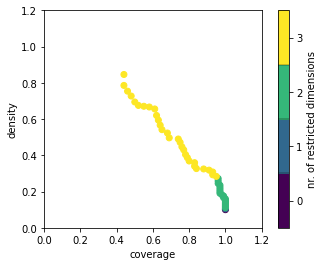

In [5]:
domain_name = "blocks-world"

# select the best 10% rows (experiments) with highest average accuracy
results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
a_avg = get_top(results, 0.1, "a_avg")

#results of PRIM algorithm (need to reload the data)
results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
box1 = find_box(results, 'a_avg', float(a_avg))

#### Step 2: set a proper box_num (need to consider the trade off between density and coverage)

In this step, we need to find a proper index of `box_num`. Our we have two functions for finding the `box_num`.

1. significance oriented: `box_num` starts from 0 (highest coverage), then iterate to the last index `box_num` = n. For each iteration, if the qp_values for all parameters are less then the significance threshold (0.05 as default), we will stop the loop and return that `box_num` index, parameter ranges and qp_values. (this method usually give us very large index)

2. trade-off oriented: in this method, we don't want to be very aggressive to get large index (high density, but low coverage), we want coverage around 0.8 or we want to find the median of index.

Nocite: you can check more detailed information to understand the logic, for example, `box1.qp` can access the qp_values of all boxes; `getattr(box1,'box_lims')` can get all parameter ranges for all domains.

In [6]:
# find ranges:
def fine_valid_range(box1, significance = 0.05):
    param_range = getattr(box1,'box_lims')
    box_length = len(param_range)
    store = None

    for i in range(1, box_length):
        qp_dict = box1.qp[i]
        valid_params = []
        for key in qp_dict.keys():
            valid = False
            if qp_dict[key][0] != -1 and qp_dict[key][0] < significance:
                valid = True

            if qp_dict[key][1] != -1 and qp_dict[key][1] < significance:
                valid = True

            if valid:
                valid_params.append(key)

        store = [i, param_range[i], qp_dict]
        if len(valid_params) == 4:
            break
            
    return store

valid_ranges = fine_valid_range(box1)
valid_ranges

[50,
       delta      lamb   phi  threshold
 0  0.003507  1.643106   0.0   0.873350
 1  4.999644  4.559851  18.5   0.999916,
 {'lamb': [0.4479682287707151, 0.4479682287707151],
  'phi': [-1.0, 3.809824258488593e-15],
  'threshold': [5.726649963684659e-14, -1.0]}]

coverage        0.44
density     0.846154
id                50
mass           0.052
mean        0.846154
res_dim            3
Name: 50, dtype: object

             box 50                                                     
                min        max                                 qp values
phi        0.000000  18.500000             [-1.0, 3.809824258488593e-15]
threshold  0.873350   0.999916             [5.726649963684659e-14, -1.0]
lamb       1.643106   4.559851  [0.4479682287707151, 0.4479682287707151]



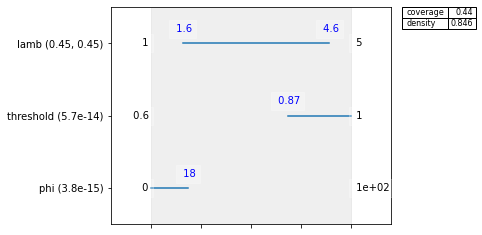

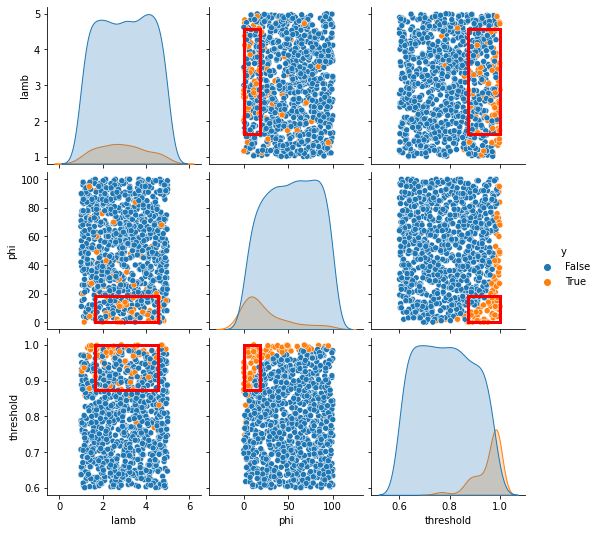

In [7]:
# inspect the box according the proper index we found.
box_num = valid_ranges[0]
show_ranges(box_num, box1)

## Show the parameter range overlaps for all domains

blocks-world


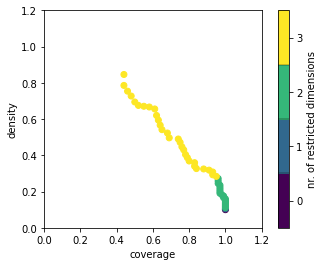

depots


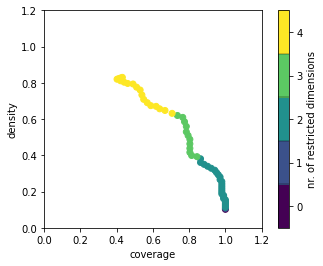

driverlog


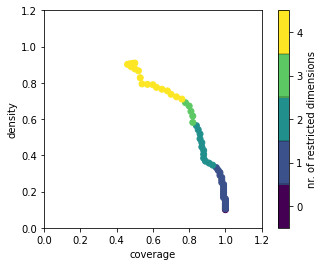

dwr


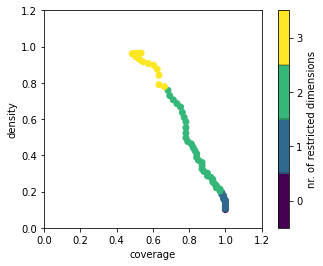

easy-ipc-grid


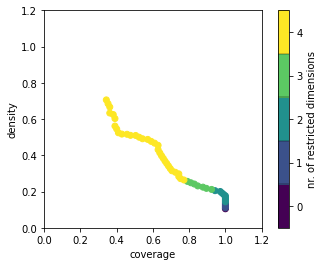

ferry


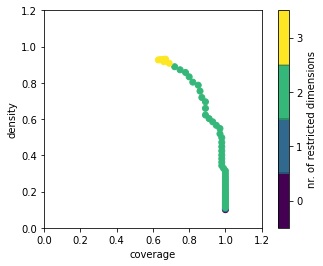

intrusion-detection


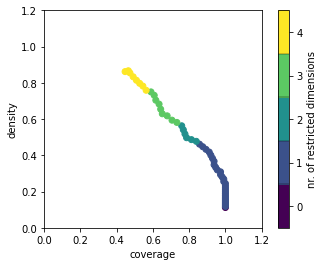

logistics


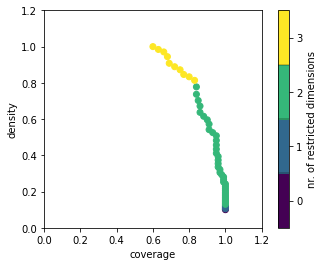

miconic


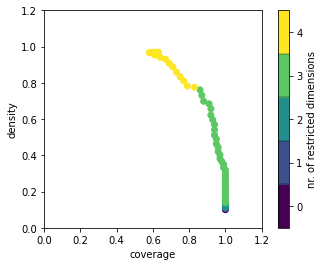

rovers


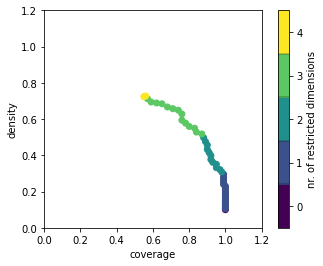

satellite


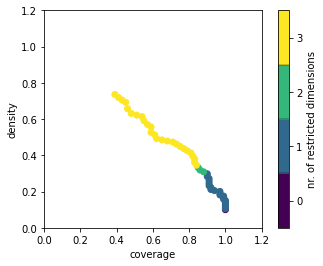

sokoban


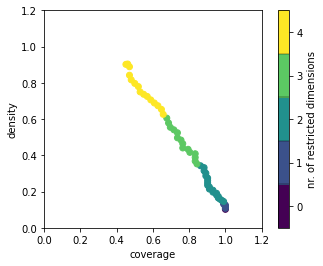

zeno-travel


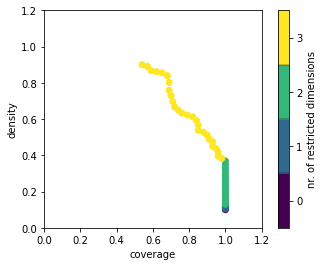

In [9]:
# Run the PRIM algorithm for all domain, store the selected ranges in param_ranges_list

# topk
"""
domain_list = ["blocks-world", "campus", "depots", "driverlog", "dwr", "easy-ipc-grid", "ferry", 
               "intrusion-detection", "kitchen", "logistics", "miconic", "rovers", "satellite", 
               "sokoban", "zeno-travel"]
"""

domain_list = ["blocks-world", "depots", "driverlog", "dwr", "easy-ipc-grid", "ferry", 
               "intrusion-detection", "logistics", "miconic", "rovers", "satellite", 
               "sokoban", "zeno-travel"]

param_ranges_list = []

for i in range(13):    #########  13 or 15
    domain_name = domain_list[i]
    
    print(domain_name)
    #PRIM
    results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
    a_avg = get_top(results, 0.1, "a_avg")

    results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
    box1 = find_box(results, 'a_avg', float(a_avg))
    
    param_ranges_list.append(fine_valid_range(box1))

phi


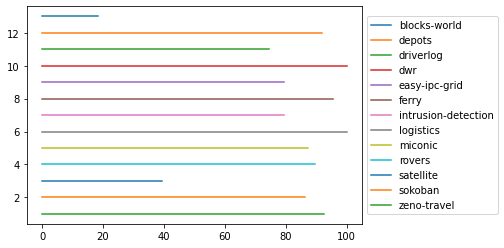

In [10]:
def show_ranges_overlap(param_ranges_list, param):
    print(param)
    for i in range(13):
        item = param_ranges_list[i]
        x_values = [item[1][param][0], item[1][param][1]]
        y_values = [13 - i, 13 - i]
        
        plt.plot(x_values, y_values)
        plt.legend(["blocks-world", "depots", "driverlog", "dwr", "easy-ipc-grid", "ferry", 
               "intrusion-detection", "logistics", "miconic", "rovers", "satellite", 
               "sokoban", "zeno-travel"], loc='center left', bbox_to_anchor=(1, 0.5))

show_ranges_overlap(param_ranges_list, "phi")

lamb


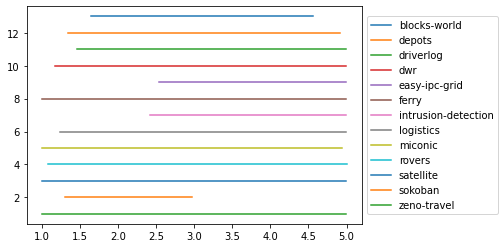

In [11]:
show_ranges_overlap(param_ranges_list, "lamb")

delta


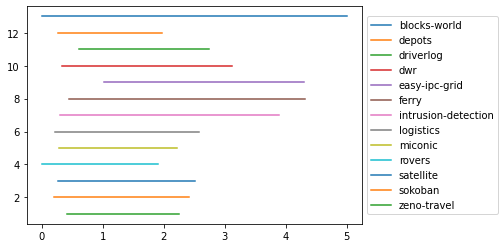

In [12]:
show_ranges_overlap(param_ranges_list, "delta")

threshold


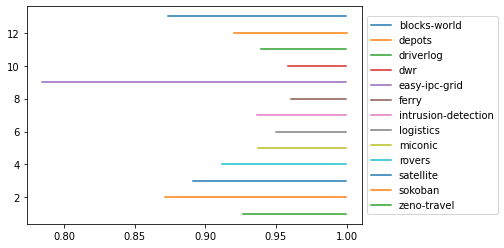

In [13]:
show_ranges_overlap(param_ranges_list, "threshold")

## SOBOL Sampling

The SOBOL analysis indicates if a parameter has significant impact on performance or not, details see [here](https://salib.readthedocs.io/en/latest/basics.html#what-is-sensitivity-analysis).

Firstly, we need to define a model as following code block. The four parameters (phi, delta, lambda, threshold) are defined as uncertainties, domain is defined as a constant, the outcomes are performance statistics (p_10, r_10, a_10, p_30, r_30, a_30, p_50, r_50, a_50, p_70, r_70, a_70, p_100, r_100, a_100, p_avg, r_avg, a_avg). The details of how to define a model can be found [here](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html)

In [14]:
from model import gr_system
import os
import sys
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ema_workbench import (RealParameter, IntegerParameter, CategoricalParameter, 
                           ScalarOutcome, Constant,
                           Model, ema_logging, perform_experiments)

domain = "a_domain_name"
model = Model('grsystem', function=gr_system)

# set uncertainties
model.uncertainties = [IntegerParameter("phi", 0,100),
                RealParameter("delta", 0, 5),
                RealParameter("lamb", 1, 5),
                RealParameter("threshold", 0.6, 1.0)]

# set domain to a constant
model.constants = [Constant("domain", domain)]

# specify outcomes
model.outcomes = [ScalarOutcome('p_10'),
                  ScalarOutcome('r_10'),
                  ScalarOutcome('a_10'),
                  ScalarOutcome('p_30'),
                  ScalarOutcome('r_30'),
                  ScalarOutcome('a_30'),
                  ScalarOutcome('p_50'),
                  ScalarOutcome('r_50'),
                  ScalarOutcome('a_50'),
                  ScalarOutcome('p_70'),
                  ScalarOutcome('r_70'),
                  ScalarOutcome('a_70'),
                  ScalarOutcome('p_100'),
                  ScalarOutcome('r_100'),
                  ScalarOutcome('a_100'),
                  ScalarOutcome('p_avg'),
                  ScalarOutcome('r_avg'),
                  ScalarOutcome('a_avg')]

#### Load the SOBOL analysis helper functions

Here we show the first order effect and total effect. And displayed SOBOL analysis results coresponding to all performance statistics (p_10, r_10, a_10, p_30, r_30, a_30, p_50, r_50, a_50, p_70, r_70, a_70, p_100, r_100, a_100, p_avg, r_avg, a_avg). Generally, we are more interested in the significance of impacts on `a_avg` (avg: accuracy).

In [15]:
# the first order and total:

from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

def show_effects(results, outcomes_field):
    experiments, outcomes = results
    problem = get_SALib_problem(model.uncertainties)
    Si = sobol.analyze(problem, outcomes[outcomes_field],
                       calc_second_order=True, print_to_console=False)

    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()
    
def display_sobol_analysis_results(results):    
    print("avg: accuracy")
    show_effects(results, 'a_avg')
    print("avg: recall")
    show_effects(results, 'r_avg')
    print("avg: precision")
    show_effects(results, 'p_avg')
    print("100: accuracy")
    show_effects(results, 'a_100')
    print("100: recall")
    show_effects(results, 'r_100')
    print("100: precision")
    show_effects(results, 'p_100')
    print("70: accuracy")
    show_effects(results, 'a_70')
    print("70: recall")
    show_effects(results, 'r_70')
    print("70: precision")
    show_effects(results, 'p_70')
    print("50: accuracy")
    show_effects(results, 'a_50')
    print("50: recall")
    show_effects(results, 'r_50')
    print("50: precision")
    show_effects(results, 'p_50')
    print("30: accuracy")
    show_effects(results, 'a_30')
    print("30: recall")
    show_effects(results, 'r_30')
    print("30: precision")
    show_effects(results, 'p_30')
    print("10: accuracy")
    show_effects(results, 'a_10')
    print("10: recall")
    show_effects(results, 'r_10')
    print("10: precision")
    show_effects(results, 'p_10')

    
# this function only show "a_avg"
def display_sobol_analysis_results_a_avg(results):    
    print("avg: accuracy")
    show_effects(results, 'a_avg')

avg: accuracy


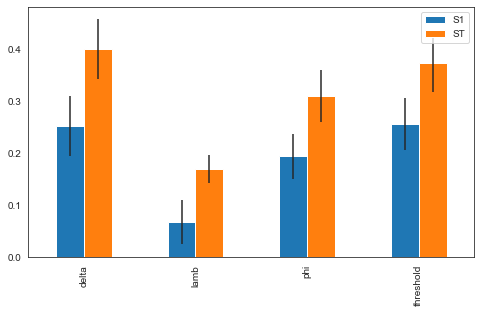

avg: recall


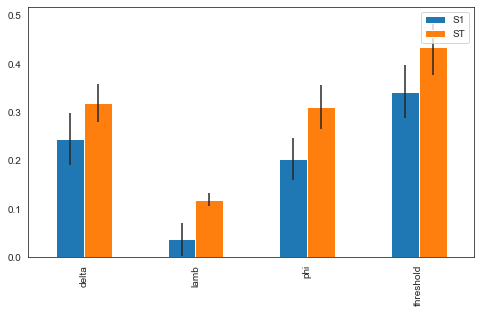

avg: precision


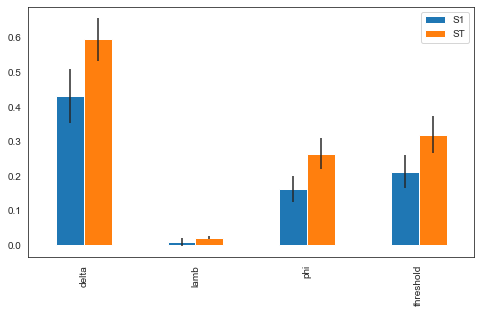

100: accuracy


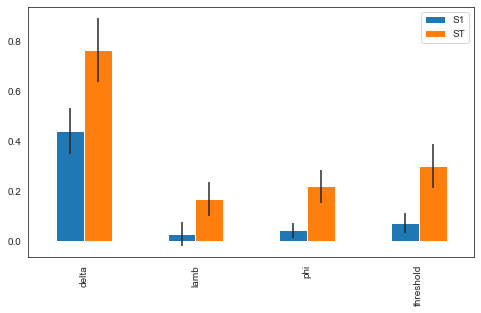

100: recall


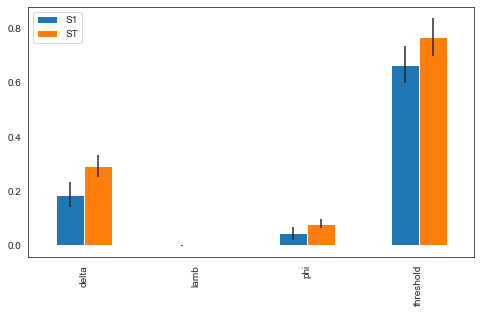

100: precision


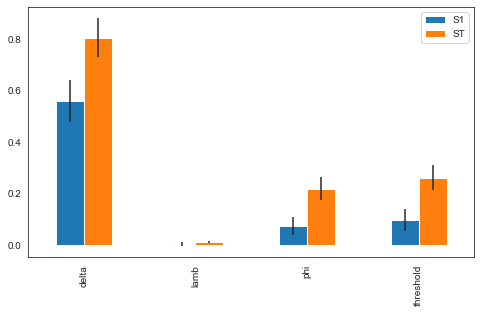

70: accuracy


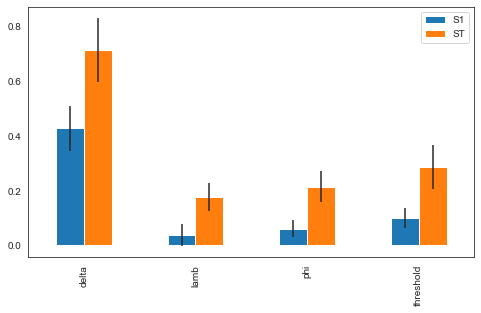

70: recall


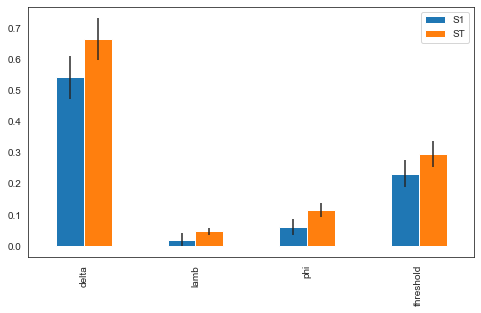

70: precision


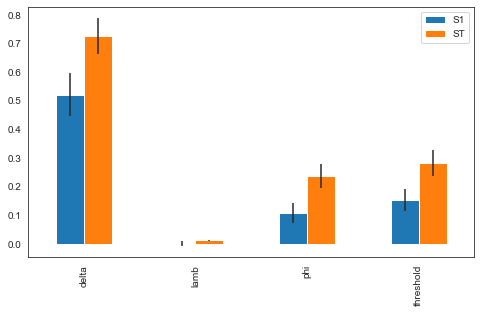

50: accuracy


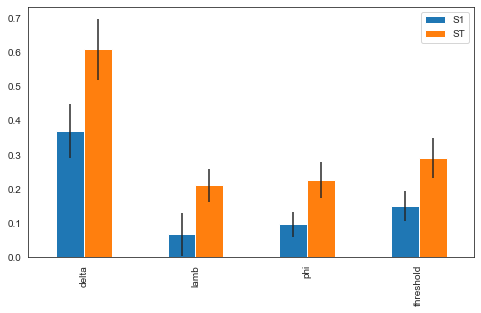

50: recall


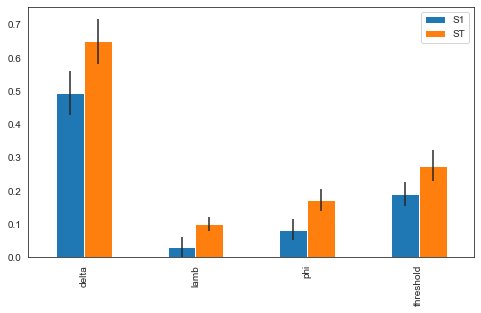

50: precision


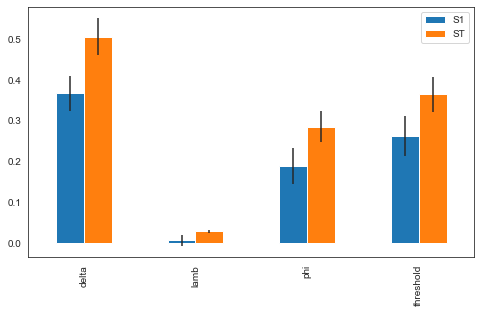

30: accuracy


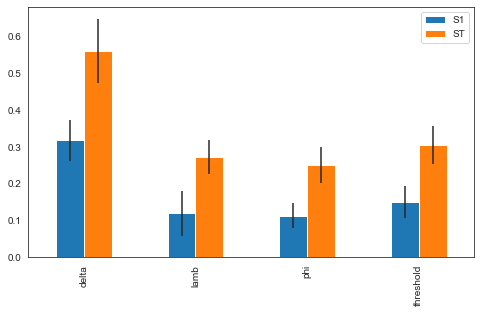

30: recall


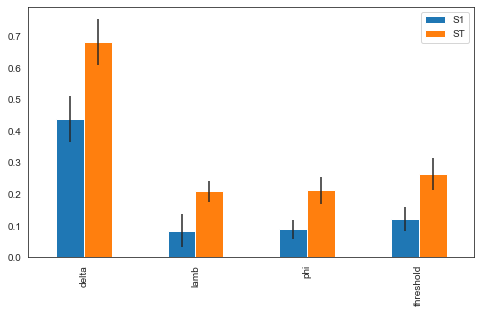

30: precision


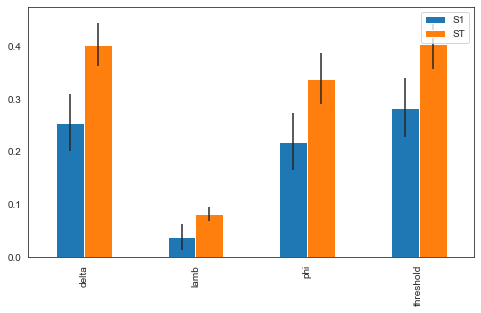

10: accuracy


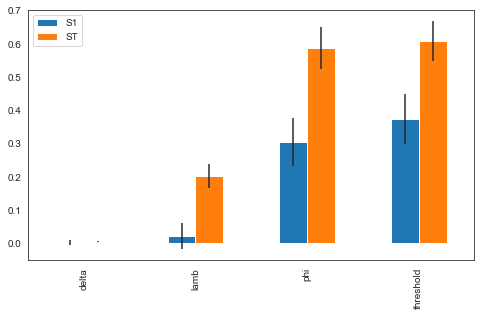

10: recall


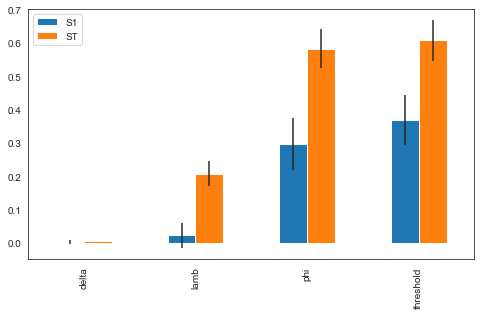

10: precision


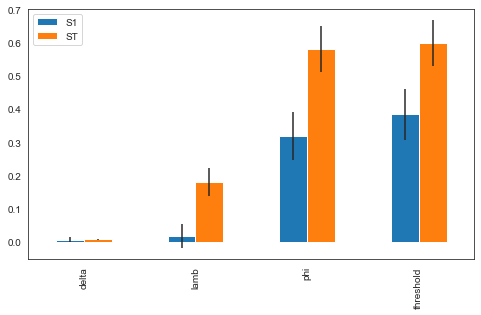

In [16]:
# load data
domain_name = "blocks-world"
sobol_results = load_results('./diverse/1050_' + domain_name + '.tar.gz')

display_sobol_analysis_results(sobol_results)

## Show results for all domains

#### The above code blocks explain and show the details of sensitivity analysis using `blocks-world` domain as an example. The following codes show a SOBOL analysis results on `a_avg` for 15 domains (including blocks-world). And also show the parameter ranges using PRIM algorithm.

blocks-world
avg: accuracy


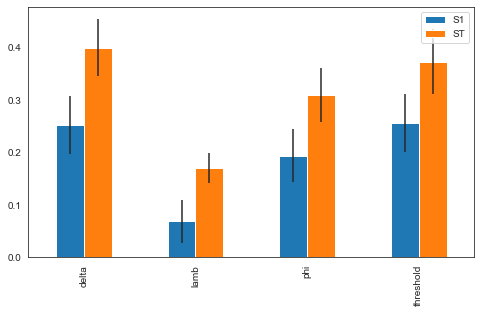

depots
avg: accuracy


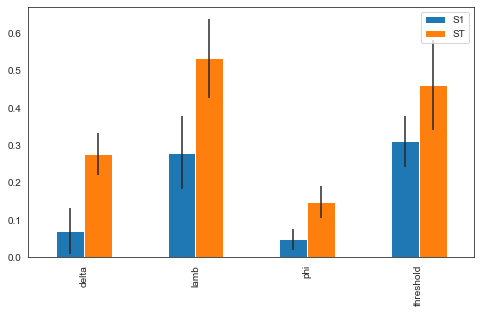

dwr
avg: accuracy


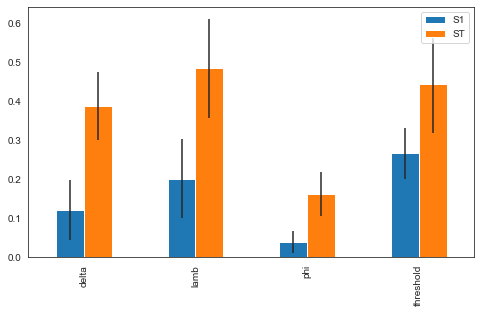

easy-ipc-grid
avg: accuracy


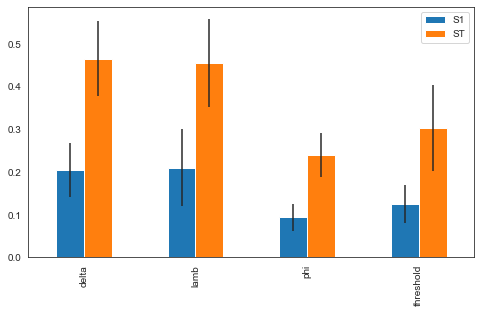

ferry
avg: accuracy


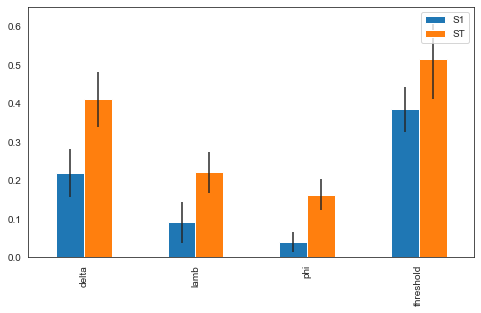

intrusion-detection
avg: accuracy


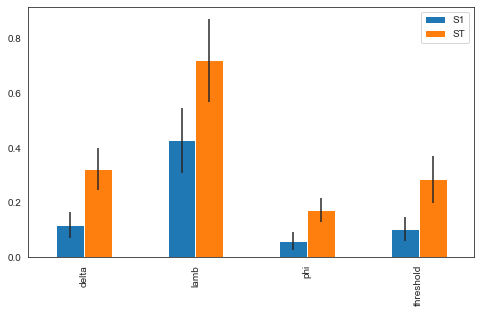

logistics
avg: accuracy


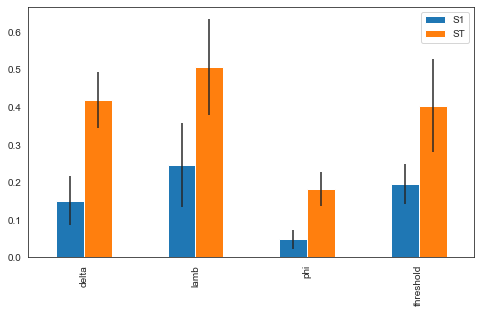

miconic
avg: accuracy


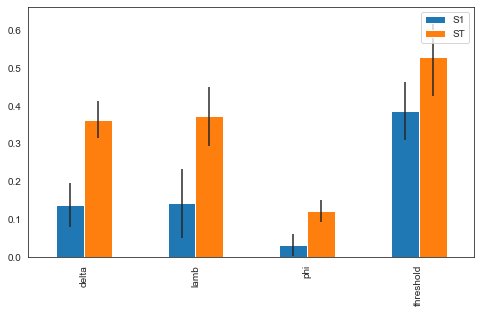

rovers
avg: accuracy


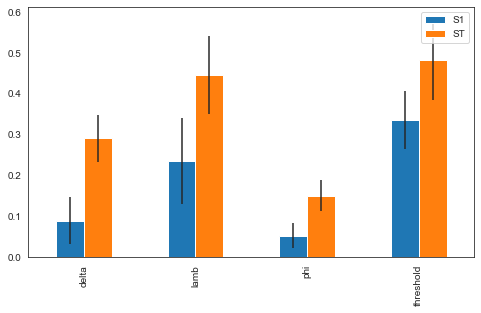

satellite
avg: accuracy


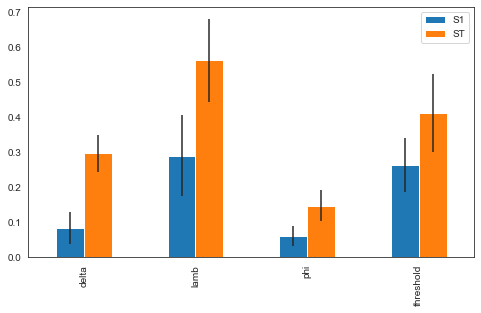

sokoban
avg: accuracy


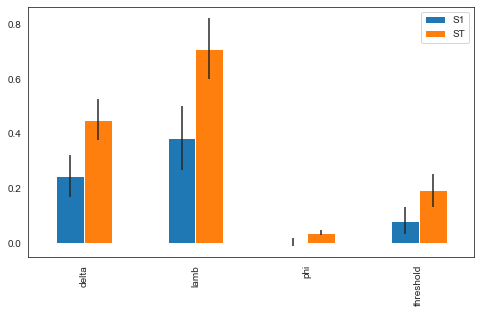

In [19]:
# There are 15 domains

domain_list = ["blocks-world", "depots", "dwr", "easy-ipc-grid", "ferry", 
               "intrusion-detection", "logistics", "miconic", "rovers", "satellite", 
               "sokoban"]

# tweak and select a proper box_num for each domain
box_num_list = [50, 25, 55, 55, 50, 50, 50, 50, 30, 50, 50, 50, 50, 50, 50]

for i in range(11):
    domain_name = domain_list[i]
    box_num = box_num_list[i]
    
    print(domain_name)
    
    """
    #PRIM
    results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
    a_avg = get_top(results, 0.1, "a_avg")

    results = load_results('./diverse/1000_' + domain_name + '.tar.gz')
    box1 = find_box(results, 'a_avg', float(a_avg))
    
    # need to use qp-value to find box_num
    show_ranges(box_num, box1)
    """

    # SOBOL
    sobol_results = load_results('./diverse/1050_' + domain_name + '.tar.gz')
    display_sobol_analysis_results_a_avg(sobol_results)